### Correlation between intratrabecular region level spatiotypes abundnace and disease group label

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

import sys
sys.path.append('../../../')

from configuration import STConfig
cfg = STConfig()
from utils.misc import environ_feats

In [28]:
def plot_association(
    statsDf,
    skey = 'sample_key',
    dkey = 'diagnosis2',
    rkey = 'it_regions',
    ENVIRON = 'ENVIRON',
    ITS = True,
    ALL=False
    ):
    
    if not ITS:
        aggregDf = statsDf.groupby(skey)[ENVIRON].value_counts(normalize=True).reset_index()
        metaDf = statsDf[[dkey, dkey]].drop_duplicates()
        plotDf = aggregDf.merge(metaDf, on=skey, how='inner')
    else:
        aggregDf = statsDf.groupby(rkey)[ENVIRON].value_counts(normalize=True).reset_index()
        metaDf = statsDf[[rkey, dkey]].drop_duplicates()
        plotDf = aggregDf.merge(metaDf, on=rkey, how='inner')

    one_hot_df = pd.get_dummies(plotDf[dkey])*1
    disease_groups = one_hot_df.columns.tolist()
    plotDf = pd.concat([plotDf, one_hot_df], axis=1)

    if ALL:
        cat_encode = {'Normal':1, 'ET':2, 'PV':3, 'MF':4}
        plotDf['All'] = plotDf[dkey].replace(cat_encode)
        disease_groups.append('All')

    # Compute Kendall tau correlation and p-values
    corr_matrix = np.zeros((len(environ_feats), len(disease_groups)))
    p_matrix = np.zeros((len(environ_feats), len(disease_groups)))

    for i, feat in enumerate(environ_feats):
        for j, disease in enumerate(disease_groups):
            sel_df = plotDf[plotDf['ENVIRON'].isin([feat])]
            tau, p_value = stats.kendalltau(sel_df['proportion'], sel_df[disease])
            corr_matrix[i, j] = tau
            p_matrix[i, j] = p_value

    # Adjust p-values for multiple testing using False Discovery Rate (FDR)
    _, p_fdr, _, _ = multipletests(p_matrix.flatten(), method='fdr_bh')
    p_fdr_matrix = p_fdr.reshape(p_matrix.shape)
    significance_mask = np.where(p_fdr_matrix < 0.05, "*", "")

    corr_df = pd.DataFrame(corr_matrix, index=environ_feats, columns=disease_groups)
    p_significance_df = pd.DataFrame(significance_mask, index=environ_feats, columns=disease_groups)

    g = sns.clustermap(
        corr_df.T, annot=p_significance_df.T, fmt='', cmap='coolwarm', center=0,
        row_cluster=True,
        linewidths=0.5, annot_kws={"size": 15, 'color':'black'}, figsize=(12, 4), yticklabels=True, vmin=-1, vmax=1, 
        tree_kws={'linewidth': 1, 'color': 'black'}
    )
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=10, rotation=90, ha='right')
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=12, rotation=0)

    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)

    g.cax.set_visible(False)

    # Rotate & align tick labels properly
    for label in g.ax_heatmap.get_xticklabels():
        label.set_fontsize(10)
        label.set_rotation(90)
        label.set_ha('center')   # center horizontally under tick

    for label in g.ax_heatmap.get_yticklabels():
        label.set_fontsize(12)
        label.set_rotation(0)
        label.set_va('center')   # center vertically on tick
        g.cax.set_aspect(2)


    plt.tight_layout()
    plt.show()

In [30]:
statsDf = pd.read_csv(cfg.pth_spatiotypes_feat_label)
skey,dkey, rkey,end_point = 'sample_key', 'diagnosis2', 'it_regions', 'Normal_vs_MF'
statsDf[skey] = statsDf['cell_id'].str[-8:].tolist()
statsDf = statsDf[statsDf['it_regions']!='non_intertrabecular']

statsDf = pd.read_csv(cfg.pth_spatiotypes_feat_label)
skey,dkey, rkey,end_point = 'sample_key', 'diagnosis2', 'it_regions', 'Normal_vs_MF'
statsDf[skey] = statsDf['cell_id'].str[-8:].tolist()
statsDf = statsDf[statsDf['it_regions']!='non_intertrabecular']

/tmp/ipykernel_104260/3779052957.py:1: DtypeWarning: Columns (8,9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  statsDf = pd.read_csv(cfg.pth_spatiotypes_feat_label)
/tmp/ipykernel_104260/3779052957.py:6: DtypeWarning: Columns (8,9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  statsDf = pd.read_csv(cfg.pth_spatiotypes_feat_label)


In [31]:
# Assigning same ID to samples belonging to same patient
group_mapping = {
    "18612_R1": "18612_R5",  # Group for R1 and R4
    "18612_R4": "18612_R5",
    "18612_R2": "18612_R6",  # Group for R2 and R3
    "18612_R3": "18612_R6"
}
statsDf[skey].replace(group_mapping, inplace=True)
statsDf[rkey] = 'R'+statsDf[rkey].astype(float).astype(int).astype(str)+'_'+statsDf[skey]
statsDf = statsDf[~statsDf[dkey].isin(['PrePMF'])]

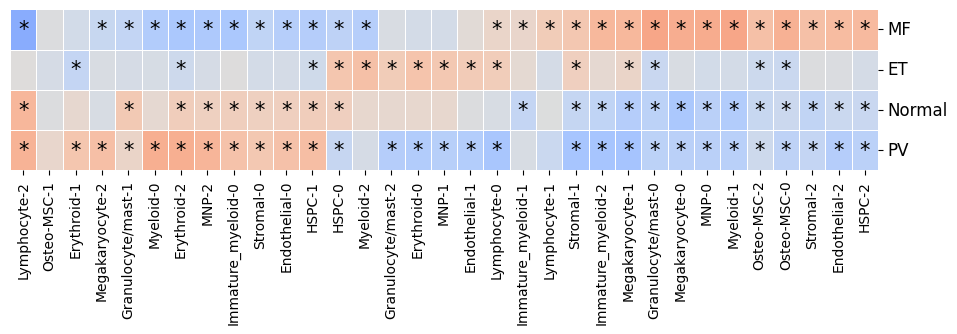

In [32]:
plot_association(statsDf)